<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/jakob/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *

In [3]:
dataset_path = '/content/gdrive/MyDrive/Capstone/Data/munich_data'

# define mask function

def mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = dataset_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)


In [6]:
# Create datablock
parks_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=mask_function,
                 item_tfms=Resize(1000),
                 batch_tfms=aug_transforms(size=1000, max_lighting=0.3)
)

# Dataloaders with batch size 4
dls4 = parks_block.dataloaders(dataset_path, bs=4)

# Dataloaders with batch size 16
dls16 = parks_block.dataloaders(dataset_path, bs=16)

# Dataloaders with batch size 32
dls32 = parks_block.dataloaders(dataset_path, bs=32)


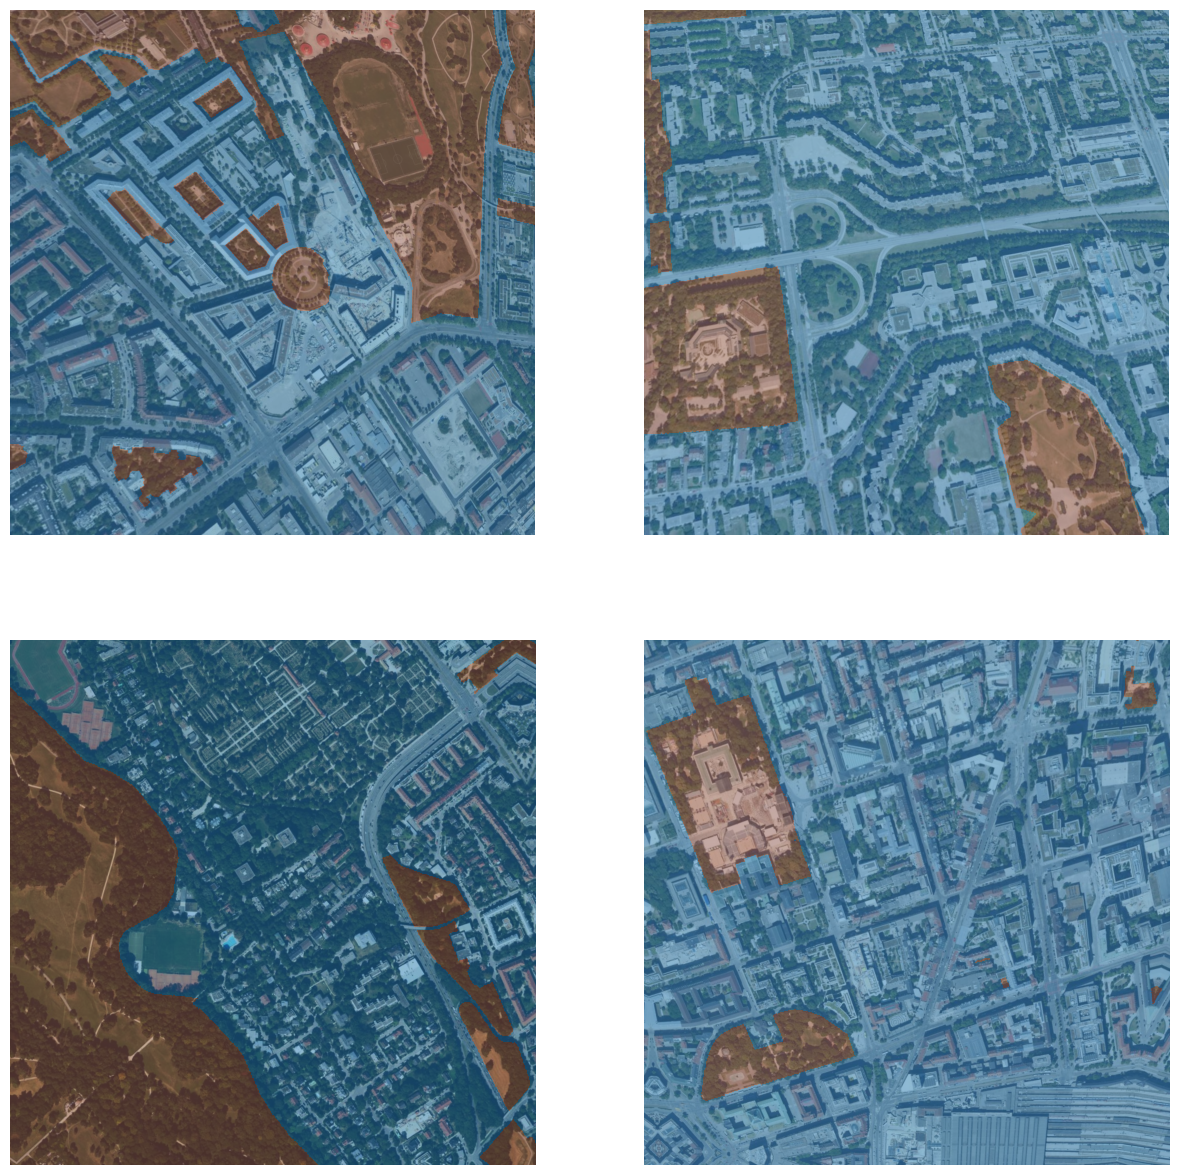

In [7]:
dls16.show_batch(figsize=(15, 15), max_n=4)

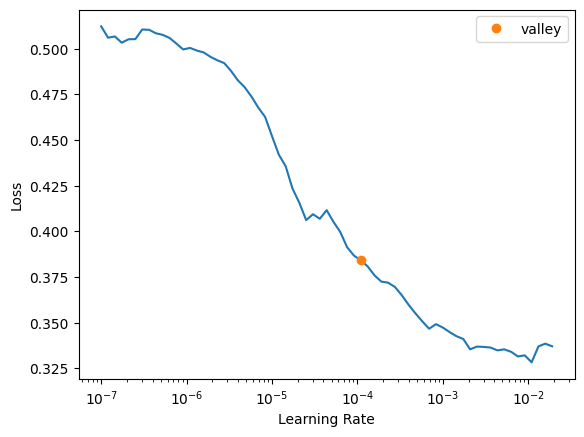

In [ ]:
# Create a U-Net model with batch size 16
learn_bs16 = unet_learner(dls16, resnet34, metrics=Dice)
lr16 = learn_bs16.lr_find()


In [ ]:
learn_bs16.fit_one_cycle(40, lr_max=lr16.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_16')])

epoch,train_loss,valid_loss,dice,time
0,0.340813,0.290209,0.000422,00:23
1,0.319446,0.276664,0.000189,00:25
2,0.296872,0.256307,0.000022,00:26
3,0.283982,0.243134,0.000006,00:24
4,0.272631,0.242486,0.000173,00:24
5,0.266452,0.223954,0.000000,00:21
6,0.253430,0.203433,0.001336,00:23
7,0.242904,0.222774,0.000022,00:22
8,0.231639,0.190866,0.005809,00:21
9,0.221615,0.192608,0.318448,00:23


Better model found at epoch 0 with dice value: 0.0004220592604522143.
Better model found at epoch 9 with dice value: 0.31844763643271906.
Better model found at epoch 10 with dice value: 0.43004095925960667.
Better model found at epoch 11 with dice value: 0.45247789225172347.
Better model found at epoch 21 with dice value: 0.4862210079870329.
Better model found at epoch 22 with dice value: 0.5169017243357709.
No improvement since epoch 22: early stopping


In [ ]:
learn_bs16 = learn_bs16.load('best_frozen_16')
print("in-sample performance: {}".format(np.array(learn_bs16.validate(ds_idx=0)[1])))

In [ ]:
def create_and_train_learner(dl, arch=resnet34, metrics=Dice, monitor='dice', epcohs=40, fname='model', act_cls=torch.nn.modules.activation.ReLU):
  learn = unet_learner(dl, arch, metrics=metrics, act_cls=act_cls)
  lr = learn.lr_find()
  learn.fit_one_cycle(40, lr_max=lr.valley, cbs=[
      EarlyStoppingCallback(monitor=monitor,
                            min_delta=0.01,
                            patience=10,
                            comp=np.greater),
      SaveModelCallback(monitor=monitor,
                        min_delta=0.01,
                        comp=np.greater,
                        fname=fname)])
  return learn

epoch,train_loss,valid_loss,dice,time
0,0.499579,0.319252,0.017782,00:26
1,0.327220,0.261442,0.005062,00:25
2,0.281051,0.237963,0.000378,00:25
3,0.249686,0.261640,0.000295,00:24
4,0.260835,0.252286,0.000033,00:26
5,0.254942,0.211320,0.000000,00:24
6,0.226666,0.198111,0.070547,00:24
7,0.226902,0.193904,0.071764,00:27
8,0.226771,0.200717,0.008892,00:27
9,0.214170,0.190742,0.024968,00:28


Better model found at epoch 0 with dice value: 0.017782275552985397.
Better model found at epoch 6 with dice value: 0.07054676521725323.
Better model found at epoch 10 with dice value: 0.42734724186904066.
Better model found at epoch 18 with dice value: 0.449638203840909.
Better model found at epoch 27 with dice value: 0.45984788317198644.
No improvement since epoch 27: early stopping


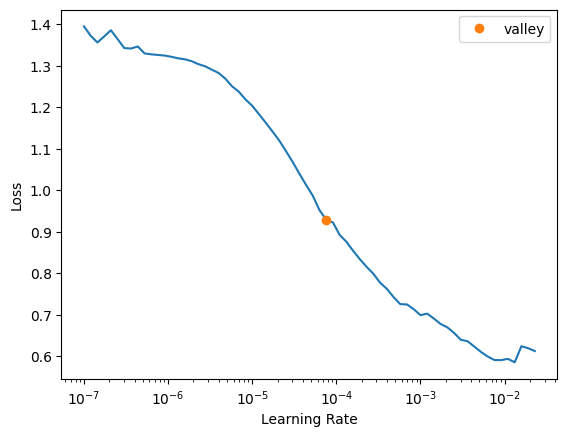

In [ ]:
learn_bs4 = create_and_train_learner(dls4, fname='best_frozen_4')

In [ ]:
learn_bs4 = learn_bs4.load('best_frozen_4')
print("in-sample performance: {}".format(np.array(learn_bs4.validate(ds_idx=0)[1])))

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


in-sample performance: 0.6546316342098916


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 150MB/s]


epoch,train_loss,valid_loss,dice,time
0,1.538426,1.026447,0.137844,00:37
1,1.259230,0.750955,0.115085,00:21
2,1.001376,0.368751,0.018259,00:22
3,0.788110,0.309301,0.000899,00:21
4,0.650237,0.279332,0.000378,00:21
5,0.556450,0.253305,0.000100,00:23
6,0.489205,0.244604,0.000067,00:21
7,0.438739,0.258667,0.000078,00:21
8,0.400231,0.225157,0.000067,00:22
9,0.366858,0.216009,0.000084,00:22


Better model found at epoch 0 with dice value: 0.13784447803514768.
No improvement since epoch 0: early stopping


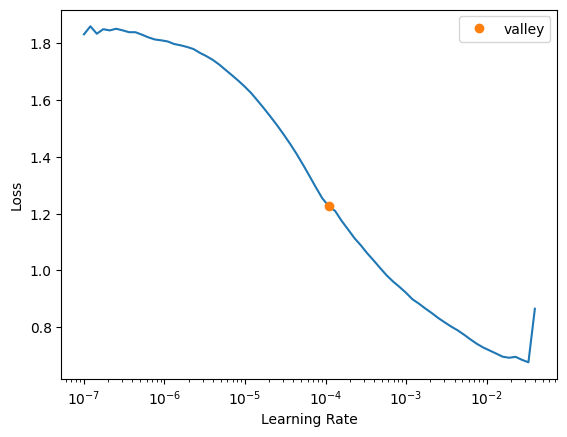

In [ ]:
learn_bs32 = create_and_train_learner(dls32, fname='best_frozen_32')


In [ ]:
learn_bs32 = learn_bs32.load('best_frozen_32')
print("in-sample performance: {}".format(np.array(learn_bs32.validate(ds_idx=0)[1])))

In the next sections we will experiment with different activation functions (ELU, LeakyReLU, GELU) with the U-Net architecture and resnet34 model, while keeping all transformations and batch size constant.


In [ ]:
# Exponential Linear Unit (ELU) activation function:

learn_ELU = create_and_train_learner(dls16, fname='best_frozen_ELU', act_cls=torch.nn.modules.activation.ELU)

KeyboardInterrupt: 

The ELU activation function drastically accelerated the learning process of the model. A dice score of over 0.5 was reached as soon as epoch 19 of training, as opposed to the previous model, which used the Rectified Linear Unit activation function, and reached a comparable dice score only after unfreezing its last layers.

In [ ]:
learn_ELU = learn_ELU.load("best_frozen_ELU")
print("in-sample performance: {}".format(np.array(learn_ELU.validate(ds_idx=0)[1])))

In [ ]:
print("our-of-sample performance: {}".format(np.array(learn_ELU.validate(ds_idx=1)[1])))

The ELU activation function provided slightly better performance than RELU.
Next, we will try the LeakyRELU activation function.

In [ ]:
learn_leaky = create_and_train_learner(dls16, fname='best_frozen_leaky', act_cls=torch.nn.modules.activation.LeakyReLU)

In [ ]:
learn_leaky = learn_leaky.load("best_frozen_leaky")
print("in-sample performance: {}".format(np.array(learn_leaky.validate(ds_idx=0)[1])))

In [ ]:
print("out-of-sample performance: {}".format(np.array(learn_leaky.validate(ds_idx=1)[1])))

In [ ]:
learn_GELU = create_and_train_learner(dls16, fname='best_frozen_GELU', act_cls=torch.nn.GELU)

In [ ]:
learn_GELU = learn_GELU.load("best_frozen_GELU")
print("in-sample performance: {}".format(np.array(learn_GELU.validate(ds_idx=0)[1])))

In [ ]:
print("out-of-sample performance: {}".format(np.array(learn_GELU.validate(ds_idx=1)[1])))

Finally we will unfreeze and train the last layers of the best model and export it.

In [ ]:
# learner = learner.load('best_frozen_model')
# learner.unfreeze()

In [ ]:
learn_bs16.export('/content/gdrive/MyDrive/Capstone/best_model.pkl')

In [ ]:

path = Path('./gdrive/MyDrive/Capstone')
path.ls()

(#6) [Path('gdrive/MyDrive/Capstone/Literature'),Path('gdrive/MyDrive/Capstone/TDS2.pdf'),Path('gdrive/MyDrive/Capstone/Data'),Path('gdrive/MyDrive/Capstone/park_images'),Path('gdrive/MyDrive/Capstone/nopark_images'),Path('gdrive/MyDrive/Capstone/best_model.pkl')]

In [ ]:
test_path = '/content/gdrive/MyDrive/Capstone/Data/wuerzburg_data'

def test_mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = test_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)




In [ ]:
test_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 get_y=test_mask_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

test_dls = test_block.dataloaders(test_path, bs=16)

best_model_path = 'gdrive/MyDrive/Capstone/best_model.pkl'
learn = load_learner(best_model_path)
learn.validate(0, test_dls[0])

(#2) [0.1725618988275528,0.0]

In [ ]:
%pip install -q typing-extensions==4.5.0 kaleido accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4

In [ ]:
import gradio as gr

best_model_path = 'gdrive/MyDrive/Capstone/best_model.pkl'
learn_app = load_learner(best_model_path)

In [ ]:
pred_img = '/content/gdrive/MyDrive/Capstone/Data/wuerzburg_data/32567_5513.jpg'
pred_mask = learn_app.predict(pred_img)[0]

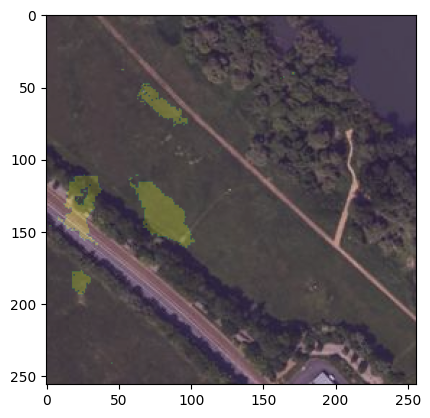

In [ ]:
rand_area = np.array(Image.open(pred_img))

plt.imshow(rand_area)
plt.imshow(pred_mask, alpha=0.2);

In [ ]:
def predict(city_image):
  pred = learn_app.predict(city_image)[0]
  return np.array(pred)

# lables = {0: 'not park', 1: 'park'}

In [ ]:
gr_interface = gr.Interface(fn=predict,
                            inputs=gr.Image(),
                            outputs=gr.AnnotatedImage())
gr_interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://3b3556f59408f15f99.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7865 <> https://3b3556f59408f15f99.gradio.live
